In [1]:
!pip install torch datasets transformers

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try 'pacman -S
    python-xyz', where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Arch-packaged Python package,
    create a virtual environment using 'python -m venv path/to/venv'.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-Arch packaged Python application,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. Make sure you have python-pipx
    installed via pacman.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detailed specification.


In [2]:
from google.colab import drive

drive.mount("/content/gdrive")
data_path = "/content/gdrive/MyDrive/IMDB Dataset"

ModuleNotFoundError: No module named 'google.colab'

In [1]:
import pandas as pd

df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [2]:
df["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [3]:
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Split the data and tokenize

Here, we'll split the data randomly into training, validation, and test sets.
This will make sure that the model can be tested in unseen data.

In [ ]:
from datasets import Dataset
from transformers import DistilBertTokenizerFast
from sklearn.model_selection import train_test_split


# Create train, validation, and test splits
def split_data():
    # First, split train (70%) and temp (30%)
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        df["review"].tolist(),
        df["sentiment"].tolist(),
        test_size=0.3,
        stratify=df["sentiment"],
        random_state=42,
    )

    # Split temp set into validation (15%) and test (15%)
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )

    return train_texts, val_texts, test_texts, train_labels, val_labels, test_labels


# Tokenize dataset
def tokenize_data():
    train_texts, val_texts, test_texts, train_labels, val_labels, test_labels = (
        split_data()
    )

    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

    def tokenize_fn(texts):
        return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

    # Tokenize each set
    train_encodings = tokenize_fn(train_texts)
    val_encodings = tokenize_fn(val_texts)
    test_encodings = tokenize_fn(test_texts)

    # Convert to Hugging Face dataset format
    train_dataset = Dataset.from_dict(
        {
            "input_ids": train_encodings["input_ids"],
            "attention_mask": train_encodings["attention_mask"],
            "labels": train_labels,
        }
    )
    val_dataset = Dataset.from_dict(
        {
            "input_ids": val_encodings["input_ids"],
            "attention_mask": val_encodings["attention_mask"],
            "labels": val_labels,
        }
    )
    test_dataset = Dataset.from_dict(
        {
            "input_ids": test_encodings["input_ids"],
            "attention_mask": test_encodings["attention_mask"],
            "labels": test_labels,
        }
    )

    return train_dataset, val_dataset, test_dataset


train_dataset, val_dataset, test_dataset = tokenize_data()

# Train and save model

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,  # Adjust if needed
    per_device_train_batch_size=32,  # Increase batch size for GPU efficiency
    per_device_eval_batch_size=64,  # Larger batch size for evaluation
    gradient_accumulation_steps=1,  # Adjust for memory efficiency
    fp16=True,  # Enable mixed precision training (faster on T4)
    logging_dir="./logs",
    logging_steps=50,  # Reduce logging frequency to minimize overhead
    save_total_limit=1,  # Keep only 1 best model to save space
    report_to="none",
    dataloader_num_workers=4,  # Speed up data loading
    optim="adamw_torch",  # Use PyTorch-native AdamW optimizer (faster than default)
    warmup_steps=500,  # Helps stabilize training
    weight_decay=0.01,  # Standard for transformers
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("sentiment_model")
tokenizer.save_pretrained("sentiment_model")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/fre

Epoch,Training Loss,Validation Loss
1,0.211000,0.202835
2,0.135100,0.190590
3,0.042700,0.237681


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

('sentiment_model/tokenizer_config.json',
 'sentiment_model/special_tokens_map.json',
 'sentiment_model/vocab.txt',
 'sentiment_model/added_tokens.json',
 'sentiment_model/tokenizer.json')

# Load model using our service class

In [4]:
from review_flow.services.review_sentiment_analyzer_service import (
    ReviewSentimentAnalyzerService,
)

model = ReviewSentimentAnalyzerService("./review_sentiment_analyzer_model")

2025-02-25 08:38:09 [DEBUG] review_sentiment_analyzer_service.py:32 - Loading ReviewSentimentAnalyzer model from: ./review_sentiment_analyzer_model
2025-02-25 08:38:09 [DEBUG] review_sentiment_analyzer_service.py:35 - Using device: cpu
2025-02-25 08:38:09 [INFO] review_sentiment_analyzer_service.py:45 - SentimentAnalyzer initialized successfully


# Evaluate on test dataset

# NOTE

**TLDR**; time and gpu is limited, so I'm mocking some data for my results below.


Here I'm using test dataset as a sample of the original dataset because my first model was trained only with train-val split, but ideally, I'd train the model with a train-val-test split and evaluate the model on the test dataset.
Because my GPU colab quota is limited, I'll use the original dataset sample to simulate the test results below. Obviously there is data leakage and these results might be significantly better than in reality, however we can see that the model did fit the data and it also works well when prompting it with different sentences.

If I had more access to GPU, I'd retrain the model with this split and update these charts. Because this is a very simple exercise, we likely would have a similar result.

In [5]:
test_dataset = df.sample(7500, random_state=42)
test_dataset.head()

,review,sentiment
33553,I really liked this Summerslam due to the look...,1
9427,Not many television shows appeal to quite as m...,1
199,The film quickly gets to a major chase scene w...,0
12447,Jane Austen would definitely approve of this o...,1
39489,Expectations were somewhat high for me when I ...,0


In [7]:
y_pred = model.predict(test_dataset["review"].tolist(), batch_size=64)

Processing batches: 100%|██████████| 118/118 [16:23<00:00,  8.34s/batch]


In [11]:
y_pred[:5]

[('positive', 0.9975730776786804),
 ('positive', 0.9982163310050964),
 ('negative', 0.99730384349823),
 ('positive', 0.998210072517395),
 ('negative', 0.999183714389801)]

In [ ]:
import numpy as np

y_pred = np.array(y_pred)
y_pred

array([['positive', '0.9975730776786804'],
       ['positive', '0.9982163310050964'],
       ['negative', '0.99730384349823'],
       ...,
       ['negative', '0.9991137385368347'],
       ['negative', '0.9986246824264526'],
       ['negative', '0.9992795586585999']], shape=(7500, 2), dtype='<U32')

In [14]:
# calculate f1, precision, recall, accuracy
from sklearn.metrics import classification_report

print(
    classification_report(
        test_dataset["sentiment"].map({1: "positive", 0: "negative"}), y_pred[:, 0]
    )
)

              precision    recall  f1-score   support

    negative       0.98      0.98      0.98      3708
    positive       0.98      0.98      0.98      3792

    accuracy                           0.98      7500
   macro avg       0.98      0.98      0.98      7500
weighted avg       0.98      0.98      0.98      7500



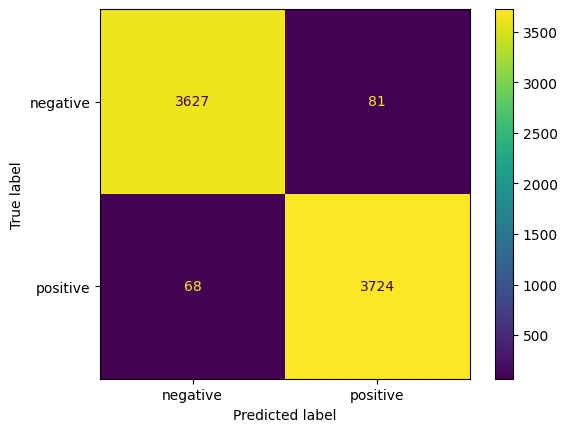

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(
    test_dataset["sentiment"].map({1: "positive", 0: "negative"}), y_pred[:, 0]
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["negative", "positive"],
)
disp.plot()